<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/FP_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### NEED TO DO

1. train:val:test split. Not done here. Used all drugs to do training (since the data is few)
2. label should be one hot encoding and use BCELoss, here just use the original [1,2,3,4,5] and used MSELoss, need to be changed
3. Did not incorporate protein expression info. Could try simple multiplication on IC$_{50}$


In [ ]:
cd /content/drive/MyDrive/tox_pred

/content/drive/MyDrive/tox_pred


In [ ]:
ls

drug_reaction_freq.tsv  drug_smiles_ic50.tsv  hpa_gene_seqs.json


In [ ]:
! rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet
! pip install pubchempy --quiet
! pip install rdkit --quiet

In [ ]:
import pandas as pd
from tqdm import tqdm
drug_freq = pd.read_table('drug_reaction_freq.tsv')
drug_freq = drug_freq.iloc[:, :-1]
drug_smiles = pd.read_table('drug_smiles_ic50.tsv')
drug_smiles = drug_smiles.iloc[:, :-1]

In [ ]:
df_all = drug_smiles.merge(drug_freq)

In [ ]:
# JUST SELETED A SUBSET OF IC50 AND FREQUENCY TO TEST CODE
small_drug_smiles = drug_smiles.iloc[:, :10]
small_drug_freq = drug_freq.iloc[:, :10]
small_df = small_drug_smiles.merge(small_drug_freq)

small_df

In [ ]:
from JAK_ML.ML_code.function import *
def process(df):
    MACCS_list = smile_list_to_MACCS(df['SMILES'].tolist())
    header = ['bit' + str(i) for i in range(167)]
    new_df = pd.DataFrame(MACCS_list, columns=header)
    new_df['SMILES'] = df['SMILES']
    new_df = new_df.merge(df)
    return new_df
data_df = process(df_all)

In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pickle
import numpy as np

class Classifier(nn.Module):
    def __init__(self, dims):
        super(Classifier, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        # self.emb = nn.GRU(h_dims[-1], h_dims[-1])
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        return x

def onehot(k):
    def encode(label):
        y = torch.zeros(len(label), k+1)
        for i, j  in enumerate(label):
            if j.item() <= k: y[i][int(j.item())] = 1
        return y[:, 1:]
    return encode
# onehot(5)(ae)

class tox_dataset(Dataset):
    def __init__(self, df):
        self.len = len(df)
        self.df = df
        self.ic_start_ind = df.columns.get_loc("TSPAN6")
        self.ae_start_ind = df.columns.get_loc('asthenia')

    def __getitem__(self, idx):
        """
        OUTPUT
        :param fp: fingerprint, should be 167 dim
        :param ic: ic50
        :param ae: adverse events
        """
        header = ['bit' + str(i) for i in range(167)]
        fp = self.df[header]
        fp = torch.tensor([float(b) for b in fp.iloc[idx]], dtype=torch.float32)
        ic = self.df.iloc[:, self.ic_start_ind:self.ae_start_ind]
        ic = torch.tensor(ic.values.astype(np.float32))[idx]
        ae = self.df.iloc[:, self.ae_start_ind:]
        ae = torch.tensor(ae.values.astype(np.float32))[idx]
        # ae = onehot(5)(ae)
        return fp, ic, ae
    def __len__(self): return self.len


In [ ]:
# dataset test, select first row
fp, ic, ae = tox_dataset(data_df)[0]
fp, ic, ae

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0.]),
 tensor([6.4357, 3.7920, 3.4914,  ..., 2.8832, 6.8523, 3.1793]),
 tensor([   4.,    4.,    4.,    5.,    5.,    5.,    4.,    5.,    4.,    4.,
            4.,    5.,    4.,    4.,    4.,    5.,    5., -100., -100., -100.,
         -100., -

In [ ]:
# hidden dims of neural network are changeable,
# as long as its all integers
h_dims = [256*2, 256, 128]
##############################################


# BELOW IS NOT CHANGEABLE
in_dim = fp.shape[0] + ic.shape[0]
out_dim = ae.shape[0]

dims = [in_dim, h_dims, out_dim]
dims

[15171, [512, 256, 128], 994]

In [ ]:
# batch_size is changeable
params = {'batch_size':16, 'shuffle':True,
          'drop_last':False, 'num_workers': 0}

train_loader = DataLoader(tox_dataset(data_df), **params)

In [ ]:
model = Classifier(dims)
cuda = torch.cuda.is_available()
if cuda: model = model.cuda()

In [ ]:
import torch.optim as optim
loss_function = nn.MSELoss() # better use cross entropy, need onehot encoding

# parameter changeable:
lr = 1e-3 # learning rate
wd = 1e-3 # weight decay
#######################

optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
import matplotlib.pyplot as plt
def get_min(d:dict):
    min_key = next(iter(d))
    for key in d:
        if d[key] < d[min_key]: min_key = key
    return min_key, d[min_key]

def plot_loss(a:dict):
    plt.plot(a.keys(), a.values())
    argmin, min = get_min(a)
    plt.plot(argmin, min, '*', label=f'min epoch: {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss during training')
    plt.legend()
    plt.show()
    plt.close()

Epoch 0: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 8.235


Epoch 1: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 1.633


Epoch 2: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.450


Epoch 3: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.304


Epoch 4: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.296


Epoch 5: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 1.194


Epoch 6: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.204


Epoch 7: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.294


Epoch 8: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.086


Epoch 9: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.079


Epoch 10: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.029


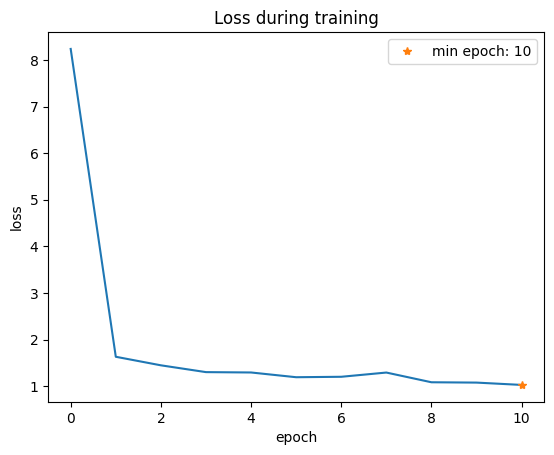

Epoch 11: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.315


Epoch 12: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


[Train] MSE loss: 1.013


Epoch 13: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.010


Epoch 14: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.040


Epoch 15: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 1.210


Epoch 16: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 1.139


Epoch 17: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.236


Epoch 18: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 1.087


Epoch 19: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 1.037


Epoch 20: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]

[Train] MSE loss: 1.041


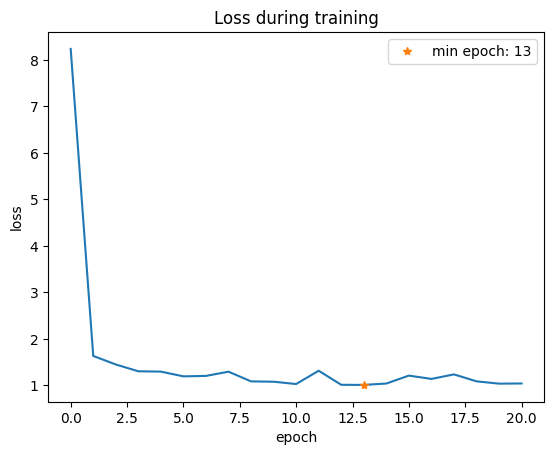

Epoch 21: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.003


Epoch 22: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.930


Epoch 23: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.951


Epoch 24: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.081


Epoch 25: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 1.004


Epoch 26: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.996


Epoch 27: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.905


Epoch 28: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.885


Epoch 29: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.896


Epoch 30: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]

[Train] MSE loss: 0.927


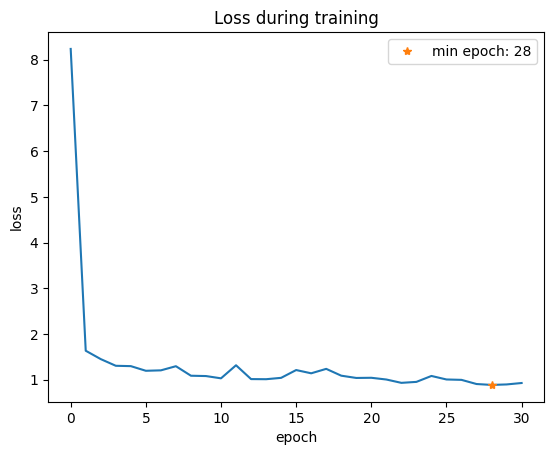

Epoch 31: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 1.025


Epoch 32: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.854


Epoch 33: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


[Train] MSE loss: 0.854


Epoch 34: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.880


Epoch 35: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.953


Epoch 36: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.928


Epoch 37: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.877


Epoch 38: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


[Train] MSE loss: 0.907


Epoch 39: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.824


Epoch 40: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]

[Train] MSE loss: 0.860


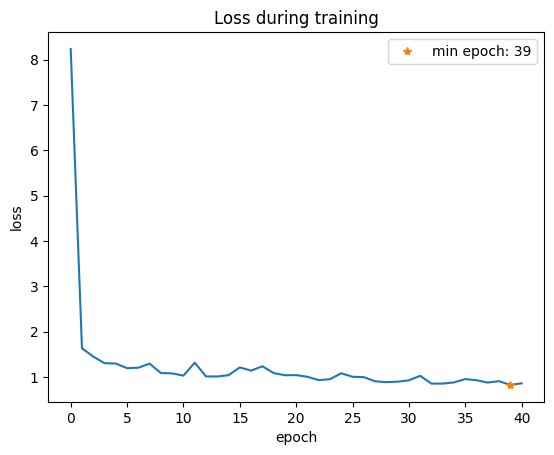

Epoch 41: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.860


Epoch 42: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.822


Epoch 43: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.801


Epoch 44: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.831


Epoch 45: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.835


Epoch 46: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.795


Epoch 47: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.792


Epoch 48: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


[Train] MSE loss: 0.806


Epoch 49: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.785


Epoch 50: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]

[Train] MSE loss: 0.798


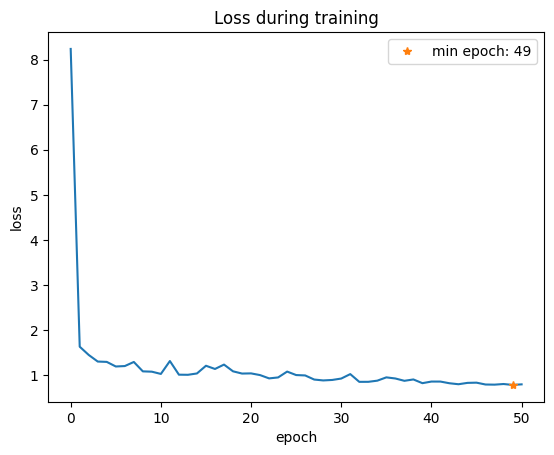

Epoch 51: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.777


Epoch 52: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.764


Epoch 53: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.823


Epoch 54: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.753


Epoch 55: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.848


Epoch 56: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.809


Epoch 57: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.798


Epoch 58: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.774


Epoch 59: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.791


Epoch 60: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.743


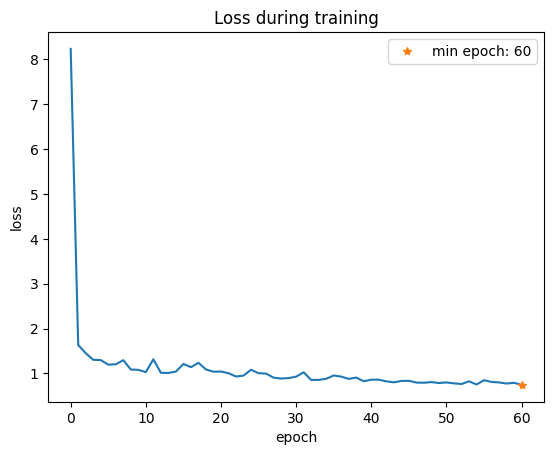

Epoch 61: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.730


Epoch 62: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.780


Epoch 63: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.712


Epoch 64: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.722


Epoch 65: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.720


Epoch 66: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.740


Epoch 67: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.671


Epoch 68: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.724


Epoch 69: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.670


Epoch 70: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]

[Train] MSE loss: 0.703


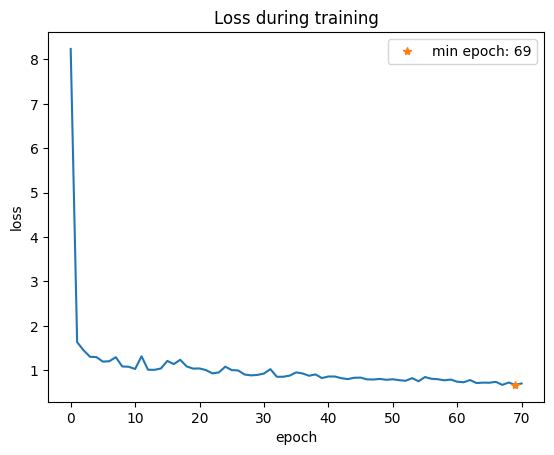

Epoch 71: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.700


Epoch 72: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.665


Epoch 73: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.719


Epoch 74: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.664


Epoch 75: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.661


Epoch 76: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.638


Epoch 77: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.653


Epoch 78: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.645


Epoch 79: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.676


Epoch 80: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]

[Train] MSE loss: 0.659


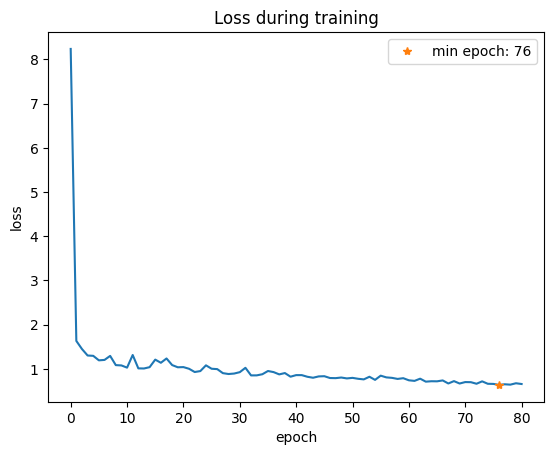

Epoch 81: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.648


Epoch 82: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.676


Epoch 83: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.629


Epoch 84: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.620


Epoch 85: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.588


Epoch 86: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.630


Epoch 87: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.606


Epoch 88: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.615


Epoch 89: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.627


Epoch 90: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


[Train] MSE loss: 0.580


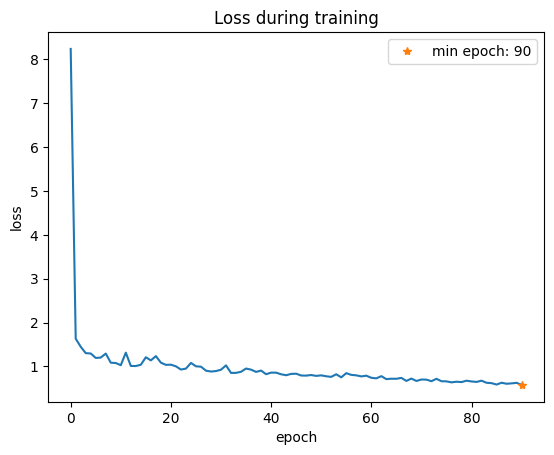

Epoch 91: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.592


Epoch 92: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.596


Epoch 93: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.611


Epoch 94: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.584


Epoch 95: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


[Train] MSE loss: 0.637


Epoch 96: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.576


Epoch 97: 100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


[Train] MSE loss: 0.558


Epoch 98: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.568


Epoch 99: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.582


Epoch 100: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


[Train] MSE loss: 0.550


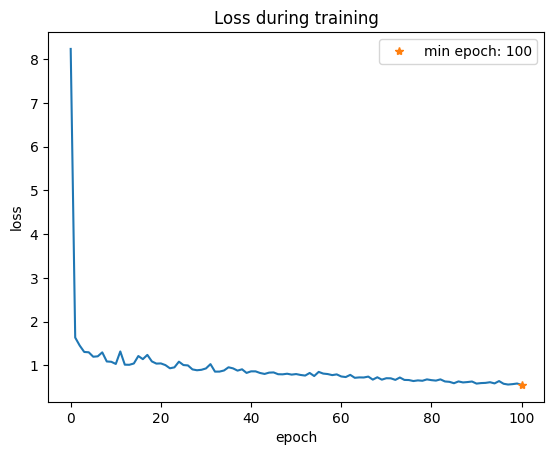

Epoch 101: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.552


Epoch 102: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.545


Epoch 103: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.556


Epoch 104: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.529


Epoch 105: 100%|██████████| 48/48 [00:45<00:00,  1.04it/s]


[Train] MSE loss: 0.557


Epoch 106: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.557


Epoch 107: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.525


Epoch 108: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.524


Epoch 109: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.546


Epoch 110: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]

[Train] MSE loss: 0.558


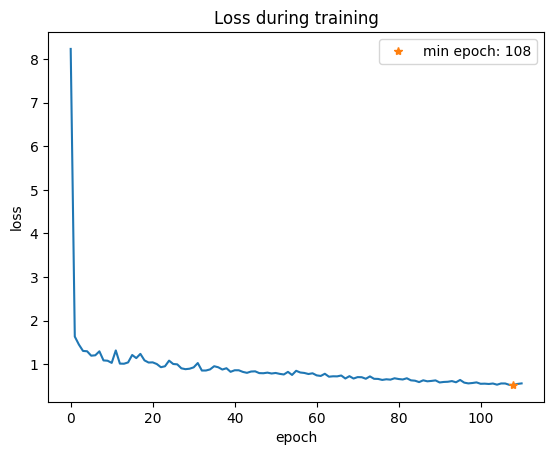

Epoch 111: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.526


Epoch 112: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.501


Epoch 113: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.524


Epoch 114: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.536


Epoch 115: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.533


Epoch 116: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.520


Epoch 117: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.496


Epoch 118: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.508


Epoch 119: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.511


Epoch 120: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]

[Train] MSE loss: 0.523


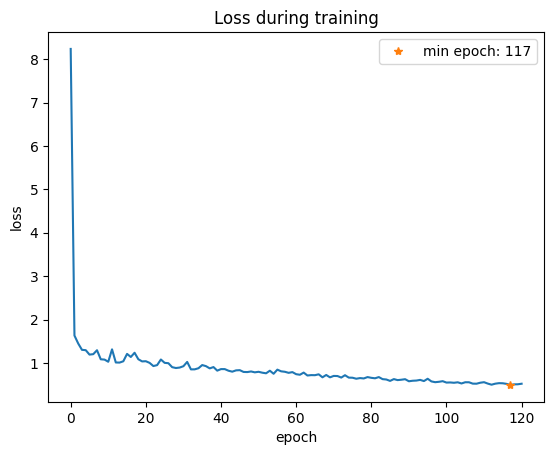

Epoch 121: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.526


Epoch 122: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.497


Epoch 123: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.501


Epoch 124: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


[Train] MSE loss: 0.525


Epoch 125: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.486


Epoch 126: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.486


Epoch 127: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.488


Epoch 128: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.496


Epoch 129: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.482


Epoch 130: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.481


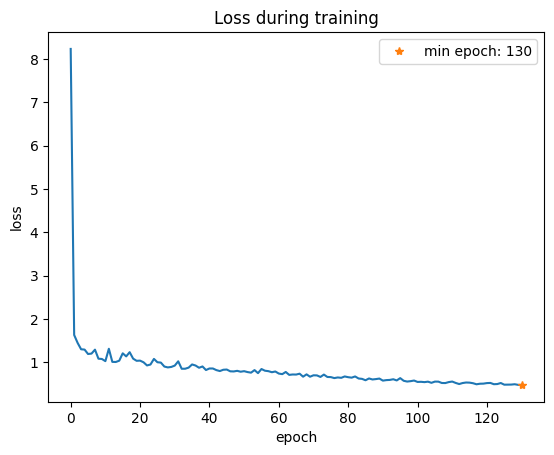

Epoch 131: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.504


Epoch 132: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.496


Epoch 133: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


[Train] MSE loss: 0.546


Epoch 134: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.522


Epoch 135: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.511


Epoch 136: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.524


Epoch 137: 100%|██████████| 48/48 [00:46<00:00,  1.04it/s]


[Train] MSE loss: 0.482


Epoch 138: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.470


Epoch 139: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.482


Epoch 140: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]

[Train] MSE loss: 0.506


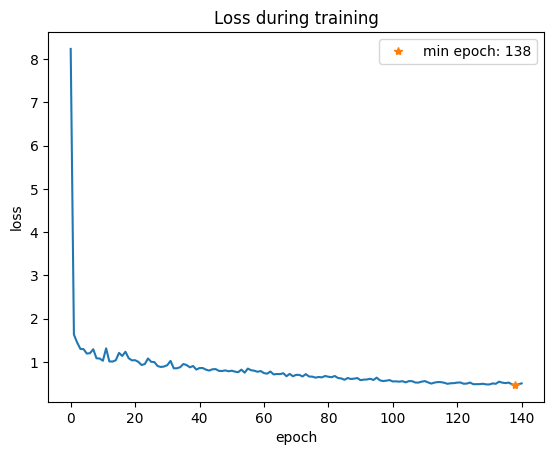

Epoch 141: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.555


Epoch 142: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.508


Epoch 143: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.464


Epoch 144: 100%|██████████| 48/48 [00:45<00:00,  1.04it/s]


[Train] MSE loss: 0.494


Epoch 145: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.499


Epoch 146: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.462


Epoch 147: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.464


Epoch 148: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.472


Epoch 149: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.520


Epoch 150: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]

[Train] MSE loss: 0.481


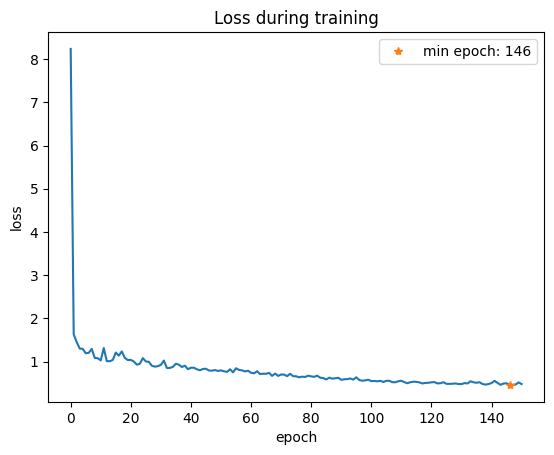

Epoch 151: 100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


[Train] MSE loss: 0.494


Epoch 152: 100%|██████████| 48/48 [00:45<00:00,  1.04it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[Train] MSE loss: 0.456
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-208-01f7bc16104c>", line 25, in <cell line: 6>
    torch.save(model.state_dict(), 'ckpt.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File ckpt.pt cannot be opened.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactives

In [ ]:
epochs = 1000
min_loss = 100000

loss_dict = {}
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i, (fp, ic, ae) in tqdm(enumerate(train_loader),
                                total=len(train_loader),
                            desc=f'Epoch {epoch}'):
        optimizer.zero_grad()
        if cuda: fp, ic, ae = fp.cuda(), ic.cuda(), ae.cuda()
        mask = ae == -100
        output = model(torch.cat((fp, ic), 1))
        loss = loss_function(output[~mask], ae[~mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader)
    print(f'[Train] MSE loss: {total_loss:.3f}')
    loss_dict[epoch] = total_loss
    if total_loss < min_loss:
        min_loss = total_loss
        torch.save(model.state_dict(), 'ckpt.pt')

    # Employ early stop
    # training too long yet no loss decrease:  STOP
    argmin, min = get_min(loss_dict)
    if epoch - argmin > 10:
        print('no decrease after 10 epoch, early stop')
        break

    # training yet see loss increase too much: STOP
    if total_loss / min > 1.3:
        print('loss increase 30% compared with min loss, early stop')
        break

    if epoch % 10 == 0 and epoch != 0:
        plot_loss(loss_dict)
